In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [36]:
# 2️⃣ Load dataset
df = pd.read_csv("data/Titanic-Dataset.csv") 

In [61]:
# FAMILY SIZE & ISALONE FEATURE
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
df["IsAlone"] = 1
df.loc[df["FamilySize"] > 1, "IsAlone"] = 0


In [62]:
# 3️⃣ Clean up any pre-existing columns
if "Survived_label" in df.columns:
    df.drop(columns=["Survived_label"], inplace=True)


In [63]:
# 4️⃣ Check columns and first rows
print("Columns:", df.columns)
print(df.head())

Columns: Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'FamilySize', 'IsAlone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  \
0         0       3    1  22.0      1      0   7.2500         2           2   
1         1       1    0  38.0      1      0  71.2833         0           2   
2         1       3    0  26.0      0      0   7.9250         2           1   
3         1       1    0  35.0      1      0  53.1000         2           2   
4         0       3    1  35.0      0      0   8.0500         2           1   

   IsAlone  
0        0  
1        0  
2        1  
3        0  
4        1  


In [64]:
# 5️⃣ Check unique values of Survived
print(df["Survived"].unique())  # Should be [0, 1]
print(df["Survived"].dtype)     # Should be int64

[0 1]
int64


In [65]:
# 6️⃣ Create human-readable labels for plotting
df["Survived_label"] = df["Survived"].map({0: "Did Not Survive", 1: "Survived"})
print(df[["Survived", "Survived_label"]].head())

   Survived   Survived_label
0         0  Did Not Survive
1         1         Survived
2         1         Survived
3         1         Survived
4         0  Did Not Survive


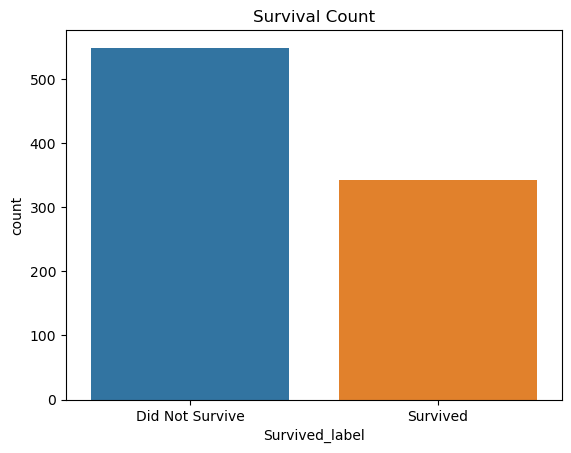

In [66]:
# 7️⃣ Plot survival counts
sns.countplot(x="Survived_label", data=df)
plt.title("Survival Count")
plt.show()

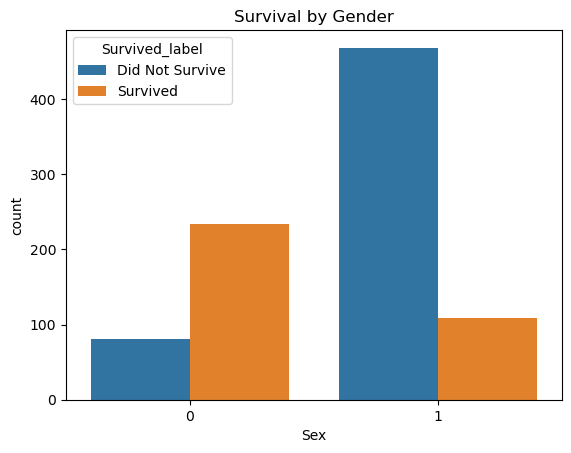

In [67]:
# Survival by Gender
sns.countplot(x="Sex", hue="Survived_label", data=df)
plt.title("Survival by Gender")
plt.show()

In [68]:
# 2️⃣ TITLE FEATURE FROM NAME (insert this BEFORE you drop 'Name')
if "Name" in df.columns:
    df["Title"] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
    df["Title"] = df["Title"].replace(
        ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'], 'Rare')
    df["Title"] = df["Title"].replace(['Mlle','Ms'], 'Miss')
    df["Title"] = df["Title"].replace('Mme', 'Mrs')

In [69]:
# 3️⃣ FILL MISSING VALUES

# Fill Age using median per Title if Title exists
if "Title" in df.columns:
    df["Age"] = df.groupby("Title")["Age"].apply(lambda x: x.fillna(x.median()))
else:
    df["Age"].fillna(df["Age"].median(), inplace=True)

# Fill Embarked with mode
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Fill Fare with median if any missing
df["Fare"].fillna(df["Fare"].median(), inplace=True)

In [70]:
# 8️⃣ Preprocessing
# Drop irrelevant columns
df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True, errors="ignore")

# Fill missing Age with median
df["Age"].fillna(df["Age"].median(), inplace=True)

# Fill missing Embarked with mode
df["Embarked"].fillna(df["Embarked"].mode()[0], inplace=True)

# Encode categorical variables
le = LabelEncoder()
df["Sex"] = le.fit_transform(df["Sex"])
df["Embarked"] = le.fit_transform(df["Embarked"])

# Features and target
X = df.drop(columns=["Survived", "Survived_label"])
y = df["Survived"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
# 4️⃣ ENCODE CATEGORICAL FEATURES (after Sex/Embarked encoding in your notebook)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in ["Sex", "Embarked", "Title"]:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])

In [72]:
# 9️⃣ RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))

Random Forest Accuracy: 0.8156424581005587
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



In [73]:
# 10️⃣ XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))

XGBoost Accuracy: 0.776536312849162
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       105
           1       0.73      0.73      0.73        74

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [16:41:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


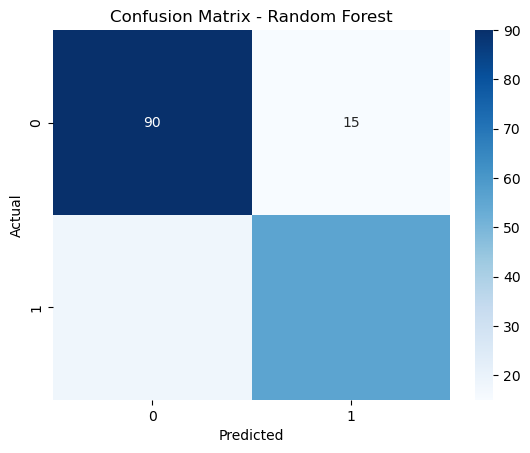

In [74]:

# Confusion Matrix for RandomForest
cm = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()